In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import keras_cv

2024-06-02 14:12:54.429345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:12:54.429426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:12:54.585487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dataset = image_dataset_from_directory(
    "/kaggle/input/100-bird-species/train",
    image_size=(224, 224),
    batch_size=96
)
test_dataset = image_dataset_from_directory(
    "/kaggle/input/100-bird-species/test",
    image_size=(224, 224),
    batch_size=96
)
validation_dataset = image_dataset_from_directory(
    "/kaggle/input/100-bird-species/valid",
    image_size=(224, 224),
    batch_size=96
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [3]:
class_names = train_dataset.class_names
np.shape(class_names)

(525,)

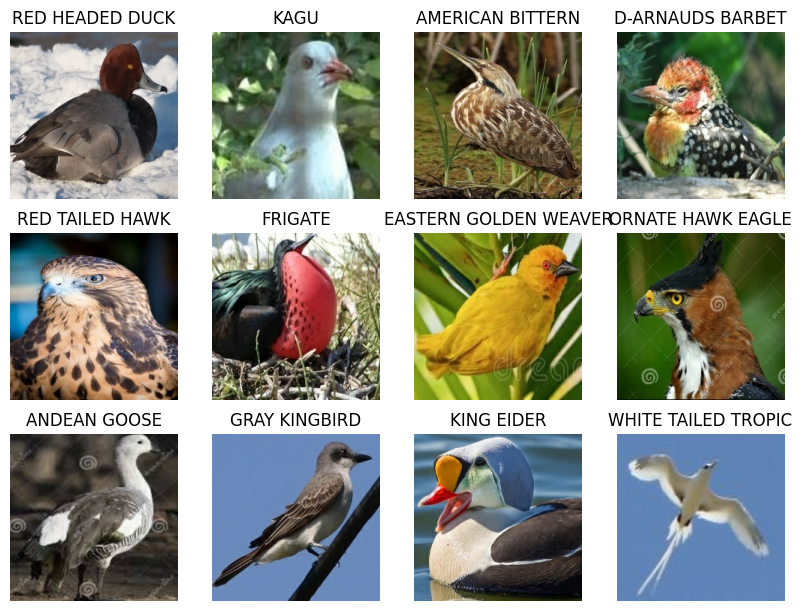

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images,labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.4),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [6]:
inputs = keras.Input(shape=(224, 224, 3))

# Apply data augmentation if needed
x = data_augmentation(inputs)

# Rescaling the input images
x = layers.Rescaling(1./255)(x)

# Load the EfficientNetV2B0 model, excluding its top layers
efficient_net = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet",
    load_weights=True,
    input_shape=(224, 224, 3),
    activation="relu"
)

# Connect the input tensor to the EfficientNetV2B0 model
x = efficient_net(x, training=True)

# Continue with custom layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(525, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b0_backbone     │ (None, 7, 7, 1280)     │     5,919,312 │
│ (EfficientNetV2Backbone)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 525)            │       538,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,774,301 (29.66 MB)

 Trainable params: 7,711,133 (29.42 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [9]:
# Define ReduceLROnPlateau callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='max',
    min_delta=0.005,
    cooldown=0,
    min_lr=0
)

# Define ModelCheckpoint callback
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="bird525.keras",
    save_best_only=True,
    monitor="val_loss"
)

# Combine both callbacks in a list
callbacks = [model_checkpoint, reduce_lr]


In [10]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10


2024-06-02 14:14:09.381662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficient_net_v2b0_backbone_1/block2b__1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


882/882 ━━━━━━━━━━━━━━━━━━━━ 596s 616ms/step - accuracy: 0.1449 - loss: 4.9226 - val_accuracy: 0.7939 - val_loss: 0.8016 - learning_rate: 5.0000e-04
Epoch 2/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 535s 606ms/step - accuracy: 0.6368 - loss: 1.4609 - val_accuracy: 0.8933 - val_loss: 0.4054 - learning_rate: 5.0000e-04
Epoch 3/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 536s 607ms/step - accuracy: 0.7558 - loss: 0.9546 - val_accuracy: 0.9269 - val_loss: 0.2796 - learning_rate: 5.0000e-04
Epoch 4/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 535s 606ms/step - accuracy: 0.8053 - loss: 0.7468 - val_accuracy: 0.9303 - val_loss: 0.2491 - learning_rate: 5.0000e-04
Epoch 5/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 563s 607ms/step - accuracy: 0.8377 - loss: 0.6127 - val_accuracy: 0.9360 - val_loss: 0.2439 - learning_rate: 5.0000e-04
Epoch 6/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 535s 606ms/step - accuracy: 0.8530 - loss: 0.5446 - val_accuracy: 0.9432 - val_loss: 0.2235 - learning_rate: 5.0000e-04
Epoch 7/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 535s 606ms/

In [14]:
test_model = keras.models.load_model(
    "bird525.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9768 - loss: 0.0944
Test accuracy: 0.976
Test accuracy: 0.091


In [12]:
# Retrieve a list of accuracy results on training and validation data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of loss results on training and validation data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

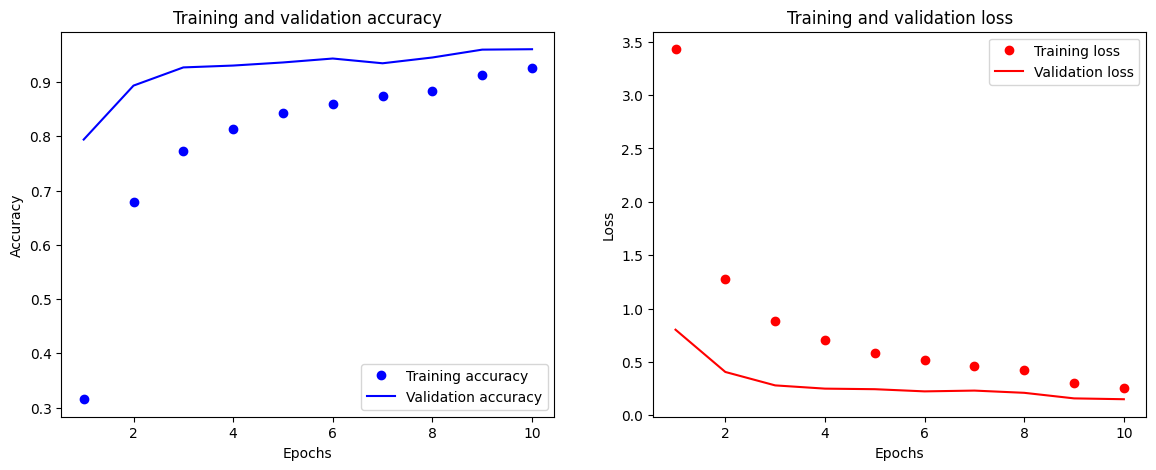

In [13]:
# Plot training and validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()